In [1]:
                                        # Imported libraries # 
import numpy as np
import csv
import matplotlib.pyplot as mp
import pandas as pd

In [2]:
                                            # Parameters # 

alfa = 0.7
Title = "BTC" # "Shiba-Inu", "RAI", "FEI", "ETH", "BTC"                # Choose the desired Asset for test
sigma_event = 3                                                              # Desired sigma event quality 

# CF constraints
absolute_percentage = 0.05
Max_CF = 0.9

# Isolated Reserve 
IR_size = 1e6

# usable data
update_period = 5 # 7                                                        # CF update period
validation_period = 28
CF_test_period = 180
csv_data = np.zeros(CF_test_period)
x_ax = np.arange(CF_test_period)

# Test asset choice
CSV_dict = {
    
    "ETH" :           'eth-usd-max.csv',
    "Shiba-Inu" :     'shib-usd.csv',
    "RAI" :           'rai-usd-max.csv',
    "FEI" :           'fei-usd-max.csv',
    "BTC" :           'btc-usd-max.csv'
}

filename = CSV_dict[Title]

In [3]:
                                        # Calculation functoins # 

def returns_calculation(P):
    returns = np.zeros(P.size-1)
    for _ in range(1, P.size):
        returns[_-1] = (P[_]/P[_-1])-1
    return returns

def STD_calculation(X):
    return np.std(X)

def random_common_week(P, period = 7):
    Prices = np.random.randint(mean_price * (1 - prices_range_ratio), mean_price * (1 + prices_range_ratio), size=period)
    return np.hstack((P[period:],Prices))

def random_week(sigma_event, P, period = 7):
    Prices = np.random.randint(mean_price * (1 - (sigma_event*prices_range_ratio)), mean_price * (1 + (sigma_event*prices_range_ratio)), size=period)
    return np.hstack((P[period:],Prices))

def daily_change(P, period = 1):
    Prices = np.random.randint(mean_price * (1 - (sigma_event*prices_range_ratio)), mean_price * (1 + (sigma_event*prices_range_ratio)), size=period)
    return np.hstack((P[period:], Prices))

def raw_formula(sigm, crash_sigm, CF_acc = 0, liq_rate=0):

    ###
    # This approach operates with returns
    # Hard liquidation (50 %)
    ###
    price_ratio = 10
    CF = (1-(2*(crash_sigm+liq_rate/100)+1)*sigm)
    Debt = CF*price_ratio
    liq_rate = 1+(liq_rate/100)
    #Upd_L = CF*(price_ratio*(1-(crash_sigm*sigm)))
    Liq = 0.5*Debt
    Liq_a2 = Liq/(price_ratio*(1-(crash_sigm*sigm)))
    Up = 1-(liq_rate*Liq_a2)
    Rest = Up*CF*(price_ratio*(1-(crash_sigm*sigm)))

    print(" CF = {:.3f}, debt = {:.3f}, rest = {:.3f}".format(CF, Debt/2, Rest))
    
    
    # !!! comparison with accurate solution (not ready yet) !!! #
    
    #alternative = Up*CF_acc*(price_ratio*(1-(crash_sigm*sigm)))
    #print(" Alternative rest = {:.3f}".format(alternative))
    
    return CF

def CF_calculation(Prices, nsigma):
    # Accurate formula (need to revise)
    
    P_init = Prices[-1]
    P_nsgima = np.mean(Prices) - (nsigma * STD_calculation(Prices))
    CF = ((2 / P_init) - (1 / P_nsgima)) #* (2 / np.mean(Prices))
    #print("CF = {:.3f}".format(CF))
    return CF

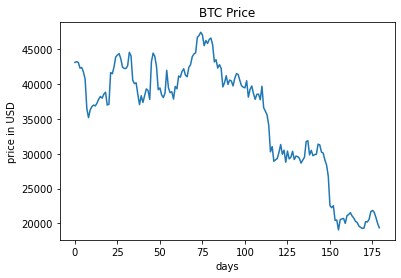

In [4]:
                                             # CSV prices file parsing #

a = np.genfromtxt(filename, delimiter=',')
lastN = a[-180:]
lastN_prices = np.zeros(lastN.shape[0])

for _ in range(lastN.shape[0]):
    lastN_prices[_] = lastN[_][1]

mp.plot(x_ax, lastN_prices)
mp.xlabel("days")                                                                               # plot prices for comparison
mp.ylabel("price in USD")
mp.title("{:.15s} Price". format(Title))
mp.show()

In [5]:

                                #################   Simulation    #################

returns = returns_calculation(lastN_prices[-28:])
std_returns = STD_calculation(returns)
# Res_acc = CF_calculation(lastN_prices[-28:]/(np.mean(lastN_prices)), sigma_event)
Res_raw = raw_formula(std_returns, 3)


Raw_plot = list()
Raw_plot_const = list()

for i in range((CF_test_period-validation_period)//update_period):
    Prices = lastN_prices[i*update_period:(i*update_period)+validation_period]

    returns = returns_calculation(Prices)#[-28:])
    std_returns = STD_calculation(returns)

    #Res_acc = CF_calculation(Prices[-28:] / (np.mean(Prices)), sigma_event)
    Res_raw = raw_formula(std_returns, 3)
    if Res_raw > Max_CF:
        Res_raw = Max_CF
    
    Res_raw_const = Res_raw
    
    # absolute constraint #
    if Raw_plot_const != [] and Res_raw_const > (1+absolute_percentage)*Raw_plot_const[-1][-1]:
        Res_raw_const = (1+absolute_percentage)*Raw_plot_const[-1][-1]

    Raw_plot.append([Res_raw]*update_period)
    Raw_plot_const.append([Res_raw_const]*update_period)

Raw_g = np.zeros(len(Raw_plot)*len(Raw_plot[0]))
Raw_g_const = np.zeros(len(Raw_plot_const)*len(Raw_plot[0]))

m = 0
for j in range(len(Raw_plot)):
    for i in range(len(Raw_plot[0])):
        Raw_g[m] = Raw_plot[j][i]
        m+=1
m = 0
for j in range(len(Raw_plot_const)):
    for i in range(len(Raw_plot_const[0])):
        Raw_g_const[m] = Raw_plot_const[j][i]
        m+=1
        

 CF = 0.747, debt = 3.733, rest = 3.868
 CF = 0.749, debt = 3.746, rest = 3.880
 CF = 0.742, debt = 3.709, rest = 3.846
 CF = 0.761, debt = 3.806, rest = 3.936
 CF = 0.746, debt = 3.730, rest = 3.865
 CF = 0.686, debt = 3.431, rest = 3.585
 CF = 0.711, debt = 3.554, rest = 3.701
 CF = 0.679, debt = 3.395, rest = 3.551
 CF = 0.689, debt = 3.444, rest = 3.597
 CF = 0.700, debt = 3.499, rest = 3.649
 CF = 0.765, debt = 3.823, rest = 3.952
 CF = 0.795, debt = 3.975, rest = 4.091
 CF = 0.831, debt = 4.154, rest = 4.255
 CF = 0.820, debt = 4.102, rest = 4.207
 CF = 0.826, debt = 4.131, rest = 4.234
 CF = 0.829, debt = 4.143, rest = 4.244
 CF = 0.826, debt = 4.129, rest = 4.232
 CF = 0.819, debt = 4.097, rest = 4.202
 CF = 0.794, debt = 3.971, rest = 4.088
 CF = 0.749, debt = 3.746, rest = 3.880
 CF = 0.739, debt = 3.697, rest = 3.835
 CF = 0.712, debt = 3.562, rest = 3.709
 CF = 0.721, debt = 3.607, rest = 3.751
 CF = 0.709, debt = 3.545, rest = 3.693
 CF = 0.757, debt = 3.784, rest = 3.916


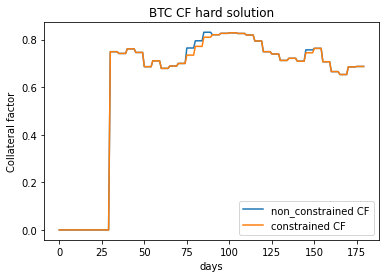

In [6]:
                    ############################# CF curve analysis ###########################################

#abs_const = np.load("Absolute_constraint.npy")
fig, ax = mp.subplots()

# plot without validation period  
#Non_constrained, = ax.plot(x_ax[validation_period:150+validation_period], Raw_g, label = "non_constrained CF")
#Constrained, = ax.plot(x_ax[validation_period:150+validation_period], Raw_g_const, label = "constrained CF")

# plot with validation period  
Non_constrained, = ax.plot(x_ax, np.hstack((np.zeros(CF_test_period - Raw_g.shape[0]), Raw_g)), label = "non_constrained CF")
Constrained, = ax.plot(x_ax, np.hstack((np.zeros(CF_test_period - Raw_g_const.shape[0]), Raw_g_const)), label = "constrained CF")

mp.xlabel("days")
mp.ylabel("Collateral factor")
mp.title("{:.15s} CF hard solution".format(Title))
ax.legend(handles = [Non_constrained, Constrained])
mp.show()